In [21]:
import sys
sys.path += ['layers']
import numpy as np
from init_layers import init_layers
from init_model import init_model
from inference import inference
from loss_euclidean import loss_euclidean
from loss_crossentropy import loss_crossentropy
from data_utils import get_CIFAR10_data

import pickle
import matplotlib.pyplot as plt

use_pcode = True
if use_pcode:
    # import the provided pyc implementation
    sys.path += ['pyc_code']
    from inference_ import inference
    from calc_gradient_ import calc_gradient
    from update_weights_ import update_weights
else:
    # import your own implementation
    from inference import inference
    from calc_gradient import calc_gradient
    from update_weights import update_weights

Load Data

TODO- make validation set?

In [2]:
X_train, y_train, X_test, y_test = get_CIFAR10_data()

Train data shape:  (32, 32, 3, 50000)
Train labels shape:  (50000,)
Test data shape:  (32, 32, 3, 10000)
Test labels shape:  (10000,)


Initalize a model

In [3]:
l = [
    init_layers("conv", {"filter_size": 2, "filter_depth": 3, "num_filters": 2}),
    init_layers("pool", {"filter_size": 2, "stride": 2}),
    init_layers("relu", {}),
    init_layers("flatten", {}),
    init_layers("linear", {"num_in": 32, "num_out": 10}),
    init_layers("softmax", {}),
]


model = init_model(
    layers=l, 
    input_size=[10, 10, 3], 
    output_size=10, 
    display=True
    )


Input size:
[10, 10, 3]
Layer 0 output size: 
(9, 9, 2)
Layer 1 output size: 
(4, 4, 2)
Layer 2 output size: 
(4, 4, 2)
Layer 3 output size: 
(32,)
Layer 4 output size: 
(10,)
Final output size:
(10,)
Provided output size (should match above):
10
(Batch dimension not included)


Set training parameters

In [25]:
learning_rate = 0.01
weight_decay = 0
batch_size = 2
save_file = 'test_model.npz'
plot_on = True
itr_to_plot = 50
numIters = 1000

In [26]:
params = {
    "learning_rate" :learning_rate, # default 0.01
    "weight_decay":weight_decay , # default 0.0005
    "batch_size" : batch_size, # default 128
    "save_file" : save_file, #default model.npz
    "plot_on" : plot_on,
    "itr_to_plot" : itr_to_plot# how many iterations between plots
    }


# Initialize training parameters
# Learning rate
lr = params.get("learning_rate", .01)
# Weight decay
wd = params.get("weight_decay", .0005)
# Batch size
batch_size = params.get("batch_size", 128)
# There is a good chance you will want to save your network model during/after
# training. It is up to you where you save and how often you choose to back up
# your model. By default the code saves the model in 'model.npz'.
save_file = params.get("save_file", 'model.npz')

plot = params.get("plot_on", True)
itr_plt = params.get("itr_to_plot", 1)

# update_params will be passed to your update_weights function.
# This allows flexibility in case you want to implement extra features like momentum.
update_params = {"learning_rate": lr,
                    "weight_decay": wd }

Set up an single input

In [27]:
input = inp = np.random.rand(10, 10, 3, 10)
label = y_train[0:10]
num_inputs = input.shape[-1]
loss = np.zeros((numIters,))
accuracy = np.zeros((numIters,))

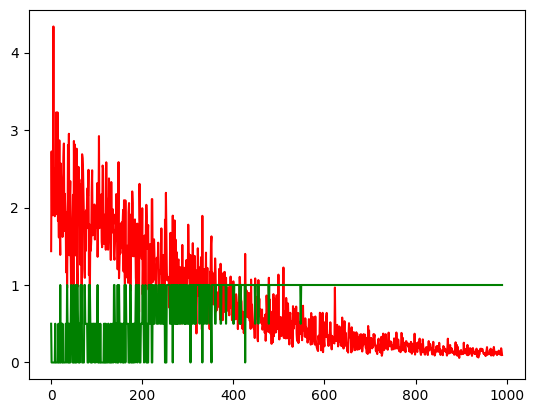

In [28]:

from IPython.display import clear_output

for i in range(numIters):
    # (1) Select a subset of the input to use as a batch
    batch_idx = np.sort(np.random.randint(0, num_inputs, batch_size))
    batch_inputs = input[:,:,:, batch_idx]
    batch_labels = label[batch_idx]

    # (2) Run inference on the batch
    output, activations = inference(model, batch_inputs)

    # (3.1) Calculate loss
    loss[i], dv = loss_crossentropy(output, batch_labels, hyper_params=None, backprop=True)
    
    # (3.2) Calculate Accuracy
    y_hat = np.argmax(output, axis=0)
    accuracy[i] = np.sum((y_hat - batch_labels) == 0) / len(batch_labels)
    
    # (4) Calculate gradients
    grads = calc_gradient(model, batch_inputs, activations, dv)

    # (5) Update the weights of the model
    model = update_weights(model, grads, hyper_params=update_params)

    # (6) Monitor the progress of training
    # TODO- how to get multiple plots to work here?
    # https://stackoverflow.com/questions/70437632/how-can-i-animate-a-matplotlib-plot-from-within-for-loop
    if plot and i % 10 == 0:
        clear_output(wait=True)
        plt.plot(range(i+1),loss[:i+1], color="red")
        plt.plot(range(i+1), accuracy[:i+1], color="green")
        plt.show()

    # (7) Save your learnt model, using ``np.savez(save_file, **model)``
    np.savez(save_file, **model)

    # return model, loss
    
